In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
%matplotlib inline

# Final Code

In [9]:
# Data preprosessing 
block_size = 3  # context
split_ratio = 0.8

with open('names.txt') as f:
    words = f.read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['$'] = 0
itos = {i: ch for ch, i in stoi.items()}


X, Y = [], []

for word in words:
    context = [0] * block_size

    for ch in word + "$":
        X.append(context)
        Y.append(stoi[ch])
        context = context[1:] + [stoi[ch]]

X = torch.tensor(X)
Y = torch.tensor(Y)

X_train, X_valid = X[:int(len(X) * split_ratio)], X[int(len(X) * split_ratio):]
Y_train, Y_valid = Y[:int(len(Y) * split_ratio)], Y[int(len(Y) * split_ratio):]

In [10]:
# Model weights and biases
emb_space = 16
hidden = 400
char_size = len(stoi)

g = torch.Generator().manual_seed(214_748_3647)
emb = torch.randn((char_size, emb_space), generator=g)
W1 = torch.randn((block_size * emb_space, hidden), generator=g) * (
    (5 / 3) / np.sqrt(block_size * emb_space)
)
b1 = torch.randn(hidden, generator=g) * 0
W2 = torch.randn((hidden, char_size), generator=g) * 0.01
b2 = torch.randn(char_size, generator=g) * 0

parameters = [emb, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad_()

In [11]:
# Training
iteration = 500_000
minbatch_size = 32

losses = []
for iter in range(iteration):
    # mini-batch
    idx = torch.randint(0, len(X_train), (minbatch_size,))
    x = X_train[idx]
    y = Y_train[idx]
    
    # Forward pass
    h = F.tanh(emb[x].view(-1, block_size * emb_space) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    for p in parameters:
        p.grad = None

    # Backward pass
    loss.backward()

    if iter < 50_000:
        learning_rate = 0.1
    elif iter < 100_000:
        learning_rate = 0.05
    elif iter < 200_000:
        learning_rate = 0.01

    # Update weights
    for p in parameters:
        p.data -= learning_rate * p.grad

    if iter % 50_000 == 0:
        h = F.tanh(emb[X_valid].view(-1, block_size * emb_space) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y_valid)
        losses.append(loss.item())

        print(f'Iter: {iter}, Loss: {loss.item()}')

Iter: 0, Loss: 3.287273406982422
Iter: 50000, Loss: 2.3561642169952393
Iter: 100000, Loss: 2.34829044342041
Iter: 150000, Loss: 2.3347649574279785
Iter: 200000, Loss: 2.3357040882110596
Iter: 250000, Loss: 2.3420369625091553
Iter: 300000, Loss: 2.3465309143066406
Iter: 350000, Loss: 2.3442869186401367
Iter: 400000, Loss: 2.3481571674346924
Iter: 450000, Loss: 2.3472743034362793


In [12]:
# Calcualte Validation Loss
h = F.tanh(emb[X_valid].view(-1, block_size * emb_space) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_valid)
loss.item()

2.3520700931549072

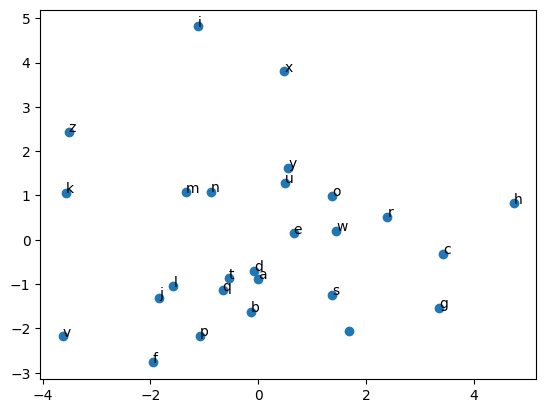

In [13]:
# see the embeddings in 2D space using PCA
from sklearn.decomposition import PCA
embeddings = np.array(emb.detach().numpy())
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])
for i, txt in enumerate(chars):
    plt.annotate(txt, (emb_2d[i, 0], emb_2d[i, 1]))
plt.show()

In [14]:
# Generate names
def generate_name():
    context = [0] * block_size
    name = ""
    for i in range(10):
        x = torch.tensor(context).view(1, -1)
        h = F.tanh(emb[x].view(-1, block_size * emb_space) @ W1 + b1)
        logits = h @ W2 + b2
        p = F.softmax(logits, dim=1).detach().numpy().flatten()
        idx = np.random.choice(np.arange(len(p)), p=p)
        if idx == 0:
            break
        name += itos[idx]
        context = context[1:] + [idx]
    return name

for _ in range(10):
    print(generate_name())

illie
ela
elliette
del
rey
emeri
sofi
hayne
cing
ryi
